# 加载模型

In [1]:
import torch
from torch import nn
import importlib
# def load_all_as_globals(module_name):
#     # 动态导入模块
#     mod = importlib.import_module(module_name)

#     # 获取模块中的所有属性名称
#     module_items = dir(mod)

#     # 遍历模块的所有属性
#     for item_name in module_items:
#         # 获取属性
#         item = getattr(mod, item_name)
#         globals()[item_name] = item
# load_all_as_globals("model-src.FDDWNet")
# model = torch.load('models/FDDWNet2.pth', weights_only=False)

# 加载数据

In [2]:
import pandas as pd
trainmeta = pd.read_csv('stats/train-meta.csv', dtype=object)
testmeta = pd.read_csv('stats/test-meta.csv', dtype=object)

# 对 model 进行可视化

### 彩图制作器

In [3]:
import numpy as np
import matplotlib.patches as mpatches
color_map = {
    0: [0, 0, 0],      # Background (黑色)
    1: [255, 165, 0],     # Inclusions (浅橙色)
    2: [30, 144, 255],    # Patches (天蓝色)
    3: [50, 205, 50],     # Scratches (亮绿色)
}
legend_patches = [
    mpatches.Patch(color=np.array(color_map[0])/255, label='Background(0)'),
    mpatches.Patch(color=np.array(color_map[1])/255, label='Inclusions(1)'),
    mpatches.Patch(color=np.array(color_map[2])/255, label='Patches(2)'),
    mpatches.Patch(color=np.array(color_map[3])/255, label='Scratches(3)'),
]
def to_rgb_im(mask):
    height, width = mask.shape
    rgb_image = np.zeros((height, width, 3), dtype=np.uint8)

    for class_idx, color in color_map.items():
        rgb_image[mask == class_idx] = color
    return rgb_image

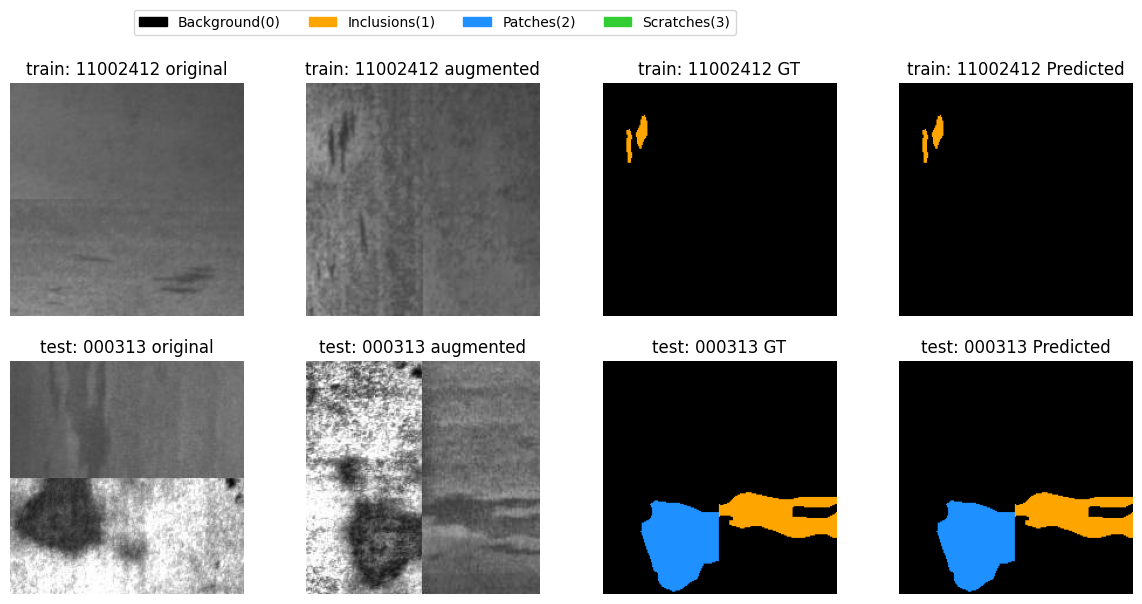

In [7]:
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from torchvision import transforms
import numpy as np
import utils.data_augmentation as data_augmentation 

transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((200, 200)),
])


def plot_result(imid:str, train:bool, axes, if_run:bool=False):
    """
        总共绘制3张图, 第一张是原图, 第二张是预测的掩码图, 第三张是GT
        args:
            imid: 希望可视化的图片的id
            train: True: 可视化训练集图片  False: 可视化测试集图片
    """
    src = "data/images/training/" if train else "data/images/testB3/"
    imdata = Image.open(src + imid + '.jpg')
    src = "data/annotations/training/" if train else "data/annotations/testB3/"
    mask = cv2.imread(src + imid + '.png', cv2.IMREAD_GRAYSCALE)
    mask = Image.fromarray(mask)
    aug_imdata, mask = data_augmentation.data_augmentation(imdata, mask)
    mask = np.array(mask)

    if if_run:
        inputs = transforms(aug_imdata).cuda().unsqueeze(0)
        with torch.no_grad():
            model.eval()
            pred = model(inputs)
            pred = torch.argmax(pred, dim=1).cpu()[0]
    else:
        pred = mask

    # 颜色转换
    mask, pred = to_rgb_im(mask), to_rgb_im(pred)

    axes[0].imshow(imdata)
    axes[0].axis('off')
    axes[0].set_title(('train' if train else 'test') + f': {imid} original')
    axes[1].imshow(aug_imdata) 
    axes[1].axis('off') 
    axes[1].set_title(('train' if train else 'test') + f': {imid} augmented')
    axes[2].imshow(mask)
    axes[2].axis('off')
    axes[2].set_title(('train' if train else 'test') + f': {imid} GT') 
    axes[3].imshow(pred)
    axes[3].axis('off')
    axes[3].set_title(('train' if train else 'test') + f': {imid} Predicted') 
fig, axes = plt.subplots(2, 4, figsize=(12, 6)) 
fig.legend(handles=legend_patches, loc='upper right', bbox_to_anchor=(0.65, 1.05), ncol=4)
plt.tight_layout(rect=[0, 0, 1, 0.95])


plot_result( np.random.choice(trainmeta['id']), True, axes[0])
plot_result( np.random.choice(testmeta['id']), False, axes[1])